# Evaluating Simpler Models on collected data

Because a Neural Net seems like overkill.

In [1]:
import os
import time
from datetime import date

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, RationalQuadratic, Exponentiation, ExpSineSquared
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.core.display import display

In [2]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"


In [3]:
def convert_datetime_to_epoch_time(date):
    return (date.astype("uint64") / 1e9).astype("uint32")

def prepare_df_for_gp(frame, prediction_column="grindersetting", encoders={}, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        try:
            new_frame = new_frame.drop([col], axis=1)
        except KeyError:
            continue
    for col, encoder in encoders.items():
        if col not in new_frame:
            print("No such column:", col)
            continue
        vals = encoder.transform(np.asarray(new_frame[col]).reshape(-1, 1))
        
        new_frame[col] = [vals[i] for i in range(len(vals))] 
        
    
    y = np.asarray(new_frame[prediction_column])
    for drop_col in [prediction_column]:
        try:
            new_frame = new_frame.drop(drop_col, axis=1)
        except KeyError:
            continue
    # Sort the columns so the ordering is consistent
    cols = list(sorted(new_frame.columns.tolist()))
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    frame_array = new_frame[cols].to_numpy()
    x = np.zeros((frame_array.shape[0], np.hstack(frame_array[0]).shape[0]))
    # Surely there is a way to vectorize this?
    for i in range(frame_array.shape[0]):
        x[i] = np.hstack(frame_array[i])
    
    return x, y

def find_columns_to_drop(df, skipped_columns=None):
    if skipped_columns is None:
        skipped_columns = set()
    droppable_columns = []
    for col in df.columns:
        if col in skipped_columns:
            continue
        # Drop any column that is mostly NaNs
        if np.count_nonzero(df[col].isna()) > 0.5 * len(df[col]):
            droppable_columns.append(col)
    return droppable_columns

In [4]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
for char in [' ', '(', ')', "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, '')
invalid_indices = df[df["time"].isna()].index
df.drop(invalid_indices, inplace=True)
df = df[pd.to_numeric(df["grindersetting"], errors="coerce").notnull()]
df["roastdate"] = pd.to_datetime(df.roastdate, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
df["date"] = pd.to_datetime(df.date, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
df["timesinceroast"] = df["date"] - df["roastdate"]
df["grindersetting"] = df["grindersetting"].astype(np.float64)
df[["roaster", "coffee"]] = df["coffee"].str.lower().str.split('-', 1, expand=True)
df["coffee"] = df["coffee"].astype(str).replace("None", "").str.strip()
df["roaster"] = df["roaster"].str.strip()
df["brewratio"] = df["output"] / df["coffeegrams"] 
for col in ["arbitraryrating1-10", "date", "details", "roastdate"]:
    df = df.drop(col, axis=1)

for col in find_columns_to_drop(df):
    print("Dropping", col)
    df = df.drop(col, axis=1)

encoded_cols = ("grinder", "coffee", "roaster", "machine")
encs = {}
for col in encoded_cols:
    if col not in df:
        print("No such column to encode", col)
        continue
    if len(df[col].unique()) <= 1:
        print(f"Column {col} has 1 or fewer values, not encoding")
        continue
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=len(df[col].unique()))
    encoder.fit(np.asarray(df[col]).reshape(-1, 1))
    encs[col] = encoder

# Drop fields that aren't going to be encoded or are a pandas type
for field in df.columns:
    if field in encs:
        continue
    if df[field].dtype == object:
        print("Dropping", field)
        df = df.drop([field], axis=1)

Dropping timeprediction
Dropping tdsatagounfiltered
Dropping tdstempc


## Evaluate using GradientBoosting to make predictions

It is feasible to build a personalized GradientBoost model, and this is to do a basic proof of concept to see if it isn't totally worthless.

With Dropped columns: ('output',)


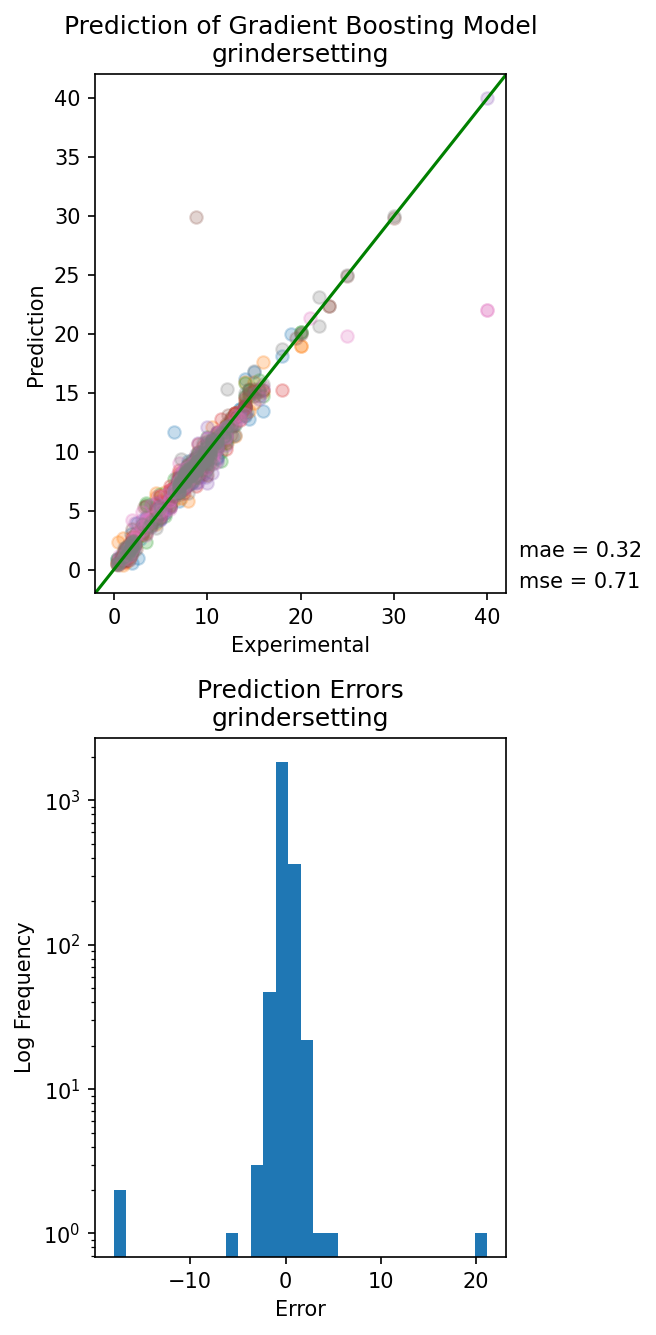

With Dropped columns: ('output',)


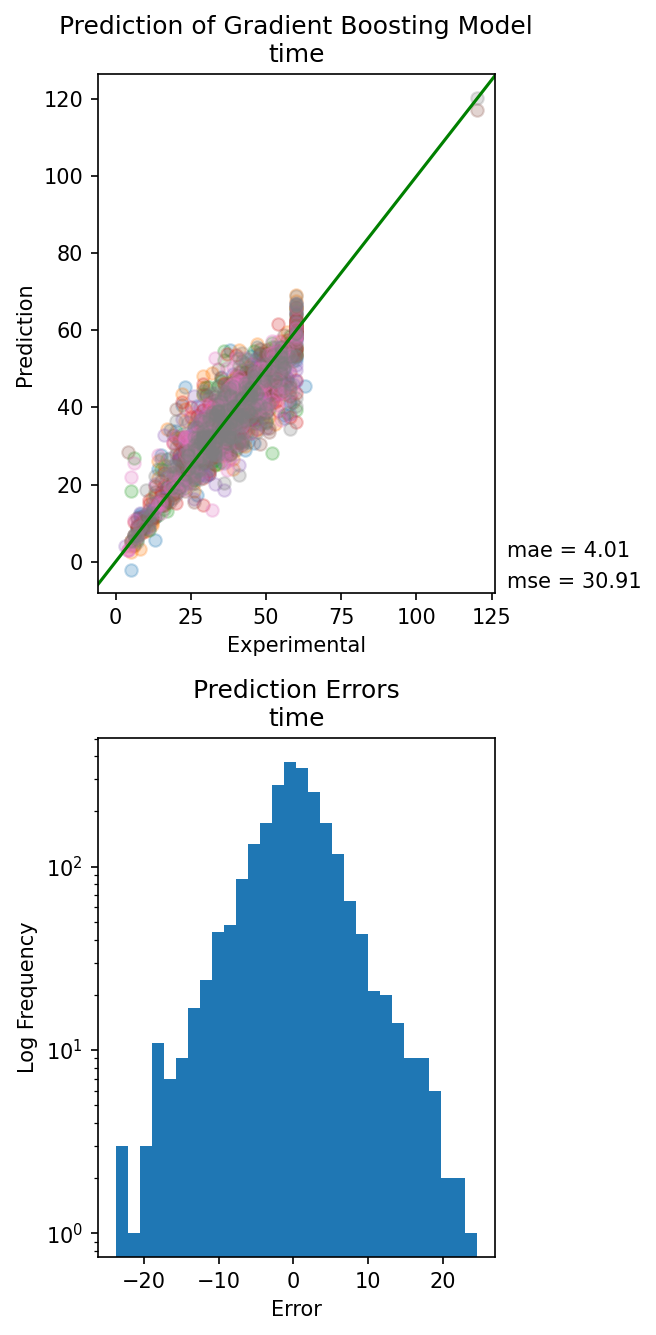

In [5]:
estimators = 2100
for prediction_field in ["grindersetting", "time"]:
    for dropped in [("output", ),]:
        print("With Dropped columns:", dropped)
        mae_scores = []
        mse_scores = []
        fig, (ax, ax2) = plt.subplots(nrows=2, dpi=150, figsize=(4.5, 9))
        x, y = prepare_df_for_gp(df, prediction_column=prediction_field, drop_cols=dropped, encoders=encs)
        folds = KFold(n_splits=8, random_state=814, shuffle=True)
        true_vals = None
        pred = None
        for train_idx, test_idx in folds.split(x):
            x_train = x[train_idx]
            y_train = y[train_idx]

            x_test = x[test_idx]
            y_test = y[test_idx]

            regr = GradientBoostingRegressor(n_estimators=estimators)
            regr.fit(x_train, y_train)

            yfit = regr.predict(x_test)
            ax.scatter(
                y_test,
                yfit,
                marker="o",
                alpha=0.25,
            )
            if true_vals is None:
                true_vals = y_test
                pred = yfit
            else:
                true_vals = np.concatenate([true_vals, y_test])
                pred = np.concatenate([pred, yfit])
            mae_scores.append(mean_absolute_error(y_test, yfit))
            mse_scores.append(mean_squared_error(y_test, yfit))
        ax.set_title(f"Prediction of Gradient Boosting Model\n{prediction_field}")
        ax.set_xlabel("Experimental")
        ax.set_ylabel("Prediction")
        ax.axline([0, 0], [1, 1], color="g", label="fit")
        ax.annotate(
            "mse = {:.2f}".format(mean_squared_error(true_vals, pred)),
            (1.03, 0.01),
            xycoords="axes fraction",
        )
        ax.annotate(
            "mae = {:.2f}".format(mean_absolute_error(true_vals, pred)),
            (1.03, 0.07),
            xycoords="axes fraction",
        )

        ax2.hist(pred - true_vals, bins=30)
        ax2.set_yscale("log")
        ax2.set_title(f"Prediction Errors\n{prediction_field}")
        ax2.set_xlabel("Error")
        ax2.set_ylabel("Log Frequency")
        fig.tight_layout()
        plt.show()

## Trying it out on new data

What happens if we throw 'novel' coffee at it, how well will it predict it across grinders?

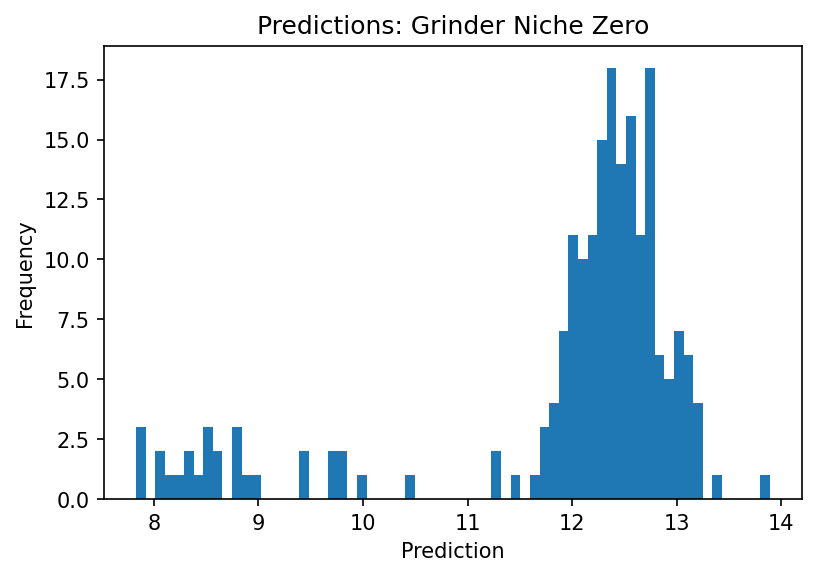

Grinder Setting Mean 11.938734170698787 Median 12.363132482113103



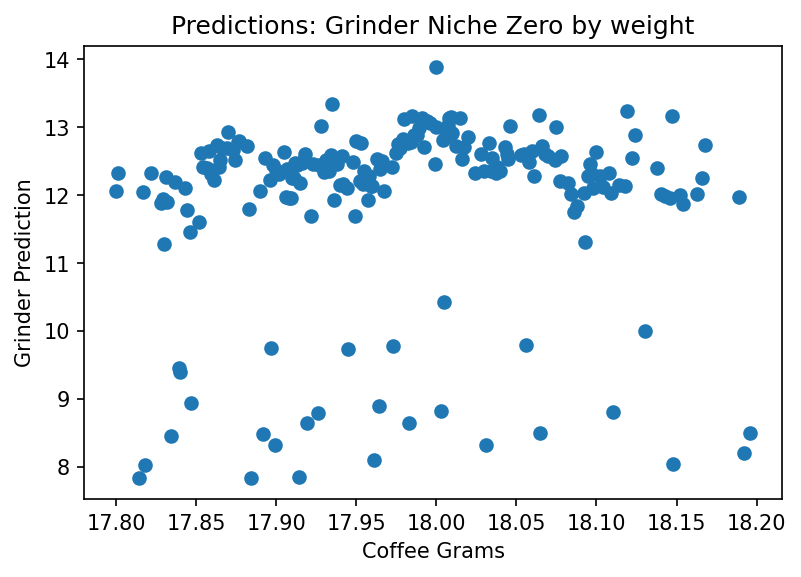

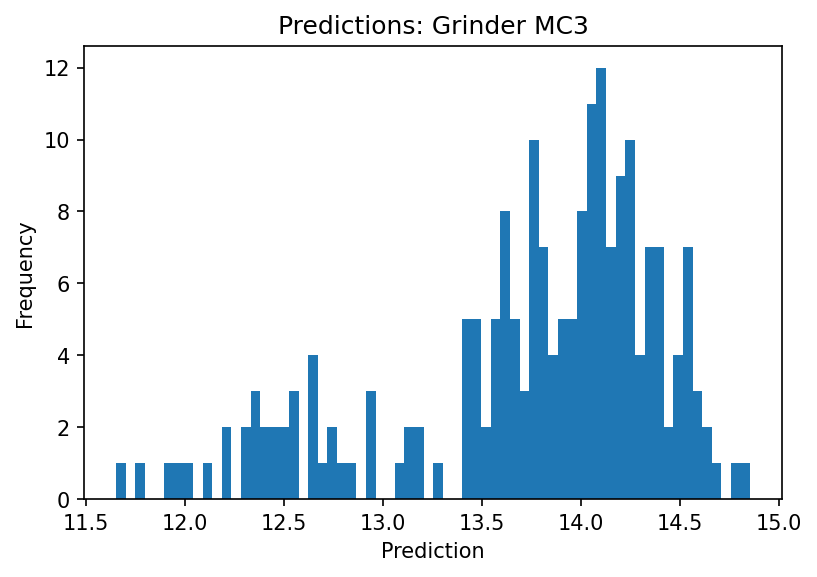

Grinder Setting Mean 13.742539410584357 Median 13.941856394394906



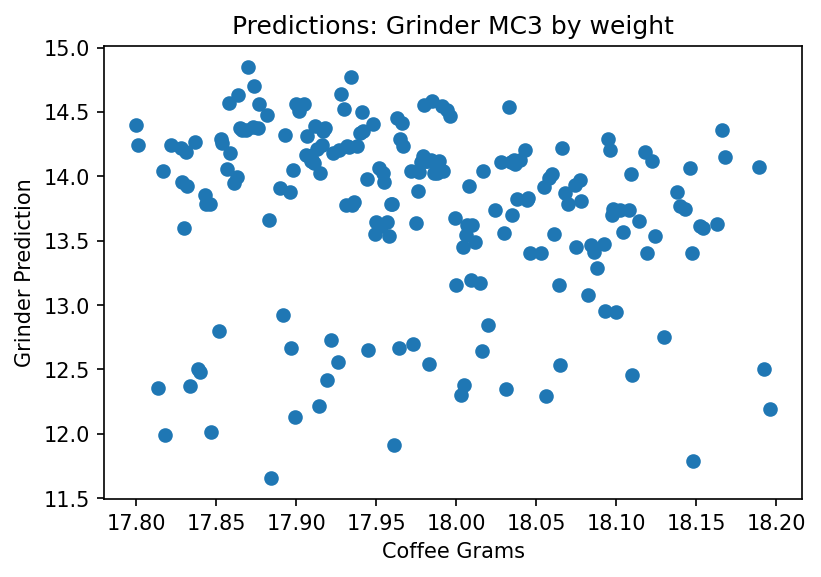

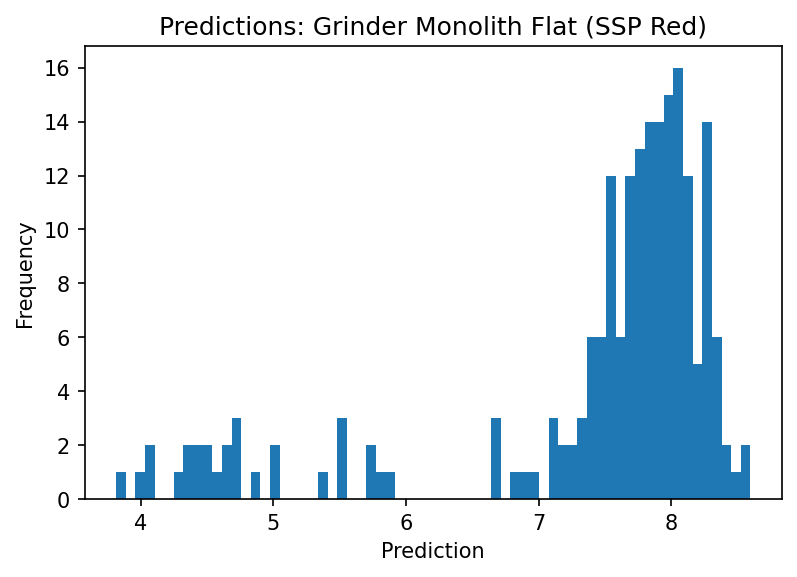

Grinder Setting Mean 7.410530177388722 Median 7.819184923591127



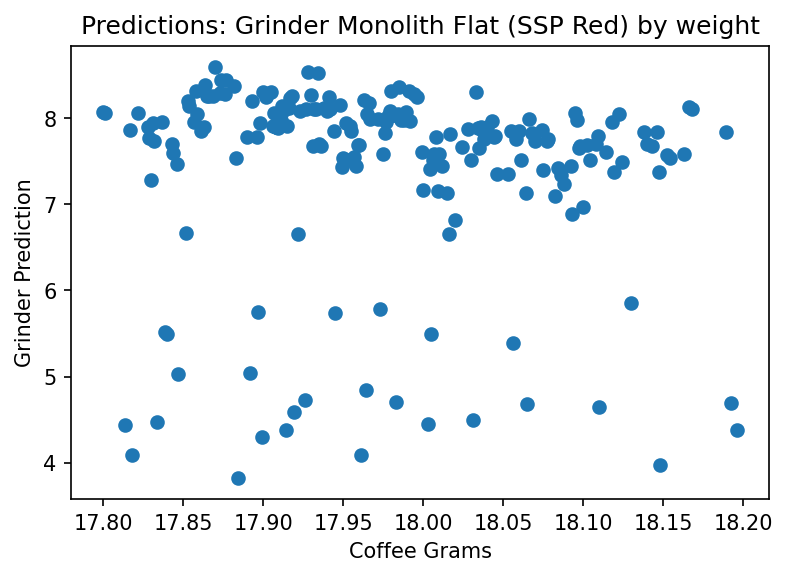

In [6]:
dropped = ("roastdate", "date", "output")
data = {
    "coffee": ["Yes Plz - Power Couple"],
    "coffeegrams": [18.0],
    "roastdate": ["12/31/21"], 
    "time": [8],
    "brewratio": [df.brewratio.median()],
    "machine": "Linea Mini"
}
x, y = prepare_df_for_gp(df, drop_cols=dropped, encoders=encs)
regr = GradientBoostingRegressor(n_estimators=2500, random_state=814)
regr.fit(x, y)

data["date"] = [date.today().strftime("%m/%d/%Y")]
data["grindersetting"] = [0.5] # Meaningless value
data["output"] = [data["brewratio"][0] * data["coffeegrams"][0]]
test_df = pd.DataFrame.from_dict(data)
test_df[["roaster", "coffee"]] = test_df["coffee"].str.lower().str.split('-', 1, expand=True)
test_df["coffee"] = test_df["coffee"].str.replace("None", "").str.strip()
test_df["roaster"] = test_df["roaster"].str.strip()
if test_df["roaster"].values[0] not in df.roaster.values:
    print("No matching roaster found", test_df["roaster"].values[0])
    print("-----")
if test_df["coffee"].values[0] not in df.coffee.values:
    print("No matching coffee found", test_df["coffee"].values[0])
    print("-----")
test_df.roastdate = pd.to_datetime(test_df.roastdate, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
test_df.date = pd.to_datetime(test_df.date, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
test_df["timesinceroast"] = test_df.date - test_df.roastdate

for grinder in df.grinder.unique():
    test_df = test_df.assign(grinder=[grinder])
    grinder_df = df[df.grinder == grinder]
    x_set = [prepare_df_for_gp(test_df, drop_cols=dropped, encoders=encs)[0][0]]
    # Look at the all the different coffeegrams values within a threshold
    for val in df.coffeegrams.unique():
        if np.abs(data["coffeegrams"][0] - val) >= 0.2:
            continue
        median_output = df[df.coffeegrams == val].output.median()
        if np.abs(median_output - data["output"][0]) > 5.0:
            continue
        test_df["coffeegrams"] = [val]
        test_df["output"] = [median_output]
        test_df["brewratio"] = test_df.output / test_df.coffeegrams
        x_test, _ = prepare_df_for_gp(test_df, drop_cols=dropped, encoders=encs)
        x_set.append(x_test[0])
        grams_idx = np.argwhere(x_set[-1] == val).reshape(-1)
    x_set = np.array(x_set)
    grams_x = x_set[:, grams_idx].reshape(-1)
    yfit = regr.predict(x_set)
    mean_pred = np.mean(yfit)
    med_pred = np.median(yfit)
    fig, ax = plt.subplots(dpi=150)
    ax.hist(yfit, bins=max(20, len(yfit) // 3))
    ax.set_title(f"Predictions: Grinder {grinder}")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Frequency")
    plt.show()
    print("Grinder Setting", "Mean", mean_pred, "Median", med_pred)
    print()
    fig, ax = plt.subplots(dpi=150)
    ax.scatter(grams_x, yfit)
    ax.set_title(f"Predictions: Grinder {grinder} by weight")
    ax.set_xlabel("Coffee Grams")
    ax.set_ylabel("Grinder Prediction")
    plt.show()